In [1]:
import os
from IPython.display import display, HTML , Markdown
import unicodedata
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.utils.data
from torch.utils.data import Subset , DataLoader , TensorDataset
from torchvision import datasets , transforms
from torchvision.datasets import ImageFolder
from torch import nn, optim
from torch.nn import CrossEntropyLoss
from torchvision.transforms import Compose, ToTensor, Resize
from numpy.random import randint , choice
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold, StratifiedShuffleSplit
import seaborn as sns
from PIL import Image
import sys
from sklearn.metrics import f1_score, accuracy_score, balanced_accuracy_score, precision_score, recall_score, confusion_matrix
from torch.utils.data import random_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import compute_class_weight
import random
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from itertools import permutations
import gc

import warnings
warnings.filterwarnings("ignore")

In [2]:
def train_val_split(dataset, split_ratio, num_classes):
    # Create a list to store the class indices
    class_indices = [[] for _ in range(num_classes)]
    
    # Get the class indices for each data point
    for i, (_, label) in enumerate(dataset):
        class_indices[label].append(i)
    
    # Create a list to store the split indices
    split_indices = []
    
    # For each class, get the split indices
    for class_index in class_indices:
        split_index = int(len(class_index) * split_ratio)
        split_indices.extend(class_index[:split_index])
    
    # Split the dataset using the split indices
    val_dataset = Subset(dataset, split_indices)
    train_indices = list(set(range(len(dataset))) - set(split_indices))
    train_dataset = Subset(dataset, train_indices)
    
    return train_dataset, val_dataset

print('split function ok!')

def undersample(images, labels, percentage):
    # Convert tensors to numpy arrays
    images = images.numpy()
    labels = labels.numpy()
    # Create a StratifiedShuffleSplit object
    sss = StratifiedShuffleSplit(n_splits=1, test_size=percentage, random_state=0)
    # Split the data using the object
    for train_index, test_index in sss.split(images, labels):
        images_undersampled = images[test_index]
        labels_undersampled = labels[test_index]
    # Convert the undersampled data back to torch tensors
    images_undersampled = torch.from_numpy(images_undersampled)
    labels_undersampled = torch.from_numpy(labels_undersampled)
    return images_undersampled, labels_undersampled

split function ok!


In [ ]:
train_img = torch.load('/kaggle/input/try000/train_img_stand0.t')
train_lab = torch.load('/kaggle/input/try000/train_lab_stand0.t')
test_img = torch.load('/kaggle/input/try000/test_img_stand0.t')
test_lab = torch.load('/kaggle/input/try000/test_lab_stand0.t')

train_img , train_lab = shuffle(train_img , train_lab)
test_img , test_lab = shuffle(test_img , test_lab)

#transform = transforms.Compose( [ transforms.ToTensor() , transforms.Normalize( mean=0.5 , std=0.5 ) ] )

RS_img , RS_lab = undersample(train_img, train_lab, percentage = 0.99)

train_dataset = TensorDataset(train_img , train_lab)
test_dataset = TensorDataset(test_img , test_lab)
RS_dataset = TensorDataset(RS_img , RS_lab)

train_ds , valid_ds = train_val_split(train_dataset , 0.2 , 5)

print(len(train_ds) , len(valid_ds) , len(RS_img) , len(RS_lab))

# GPU check
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

class_weights = compute_class_weight(class_weight='balanced', classes = [0,1,2,3,4] , y = train_lab.numpy().tolist())
Class_weights = torch.tensor(class_weights)

print(Class_weights)

In [4]:
# EXPERIMENT
class Net(nn.Sequential):
    def __init__(self, in_channels , CLASSES , n_conv_layers , n_lin_layers , outC , outL , k , drop2d , drop ,image_width , image_height):
        
        self.in_channels = in_channels
        self.CLASSES = CLASSES
        self.n_conv_layers = n_conv_layers
        self.n_lin_layers = n_lin_layers
        self.outC = outC
        self.outL = outL
        self.k = k
        self.drop2d = drop2d
        self.drop = drop
        self.image_width = image_width
        self.image_height = image_height
    
        super(Net, self).__init__()

        model = []

        #CONVOLUTIONAL LAYERS
        
        if n_conv_layers >= 1:
            model.append( nn.Conv2d( int(in_channels) , int(outC[0]) , kernel_size = 3 , stride = 1 , padding = (1,2) ) )
            model.append( nn.BatchNorm2d( int(outC[0]) ) )
            model.append( nn.ELU() )
            model.append( nn.MaxPool2d( kernel_size = 2 , stride = 2 ) )
            model.append( nn.Dropout2d( drop2d[0] ) )
            
            c = int( outC[0]*21*49 )#FLATTENING CONSTANT
            
            if n_conv_layers >= 2:
                
                model.append( nn.Conv2d( int(outC[0]) , outC[1] , kernel_size = 4 , stride = 1 , padding = 3 ) )
                model.append( nn.BatchNorm2d( int(outC[1]) ) )
                model.append( nn.ELU() )
                model.append( nn.MaxPool2d( kernel_size = 2 , stride = 2 ) )
                model.append( nn.Dropout2d( drop2d[1] ) )
                
                c = int( outC[1]*12*26 )#FLATTENING CONSTANT
                
                if n_conv_layers >= 3:

                    model.append( nn.Conv2d( int(outC[1]) , outC[2] , kernel_size = 3 , stride = 1 , padding = (1,0) ) )
                    model.append( nn.BatchNorm2d( int(outC[2]) ) )
                    model.append( nn.ELU() )
                    model.append( nn.MaxPool2d( kernel_size = 2 , stride = 2 ) ) 
                    model.append( nn.Dropout2d( drop2d[2] ) )
                    
                    c = int( outC[2]*5*13 )#FLATTENING CONSTANT
                    
                    if n_conv_layers == 4:

                        model.append( nn.Conv2d( int(outC[2]) , outC[3] , kernel_size = 2 , stride = 1 , padding = 1 ) )
                        model.append( nn.BatchNorm2d( int(outC[3]) ) )
                        model.append( nn.ELU() )
                        model.append( nn.MaxPool2d( kernel_size = 2 , stride = 2 ) ) 
                        model.append( nn.Dropout2d( drop2d[3] ) )
                        
                        c = int( outC[3]*3*7 )#FLATTENING CONSTANT
        
        self.cnn_layers = nn.Sequential(*model)
    
        model2 = []
        
        #model2.append( nn.ELU() )
        
        #NO DEEP LINEAR LAYERS
        if n_lin_layers == 0:
            
            model2.append( nn.Linear( c , CLASSES ) )

        #DEEP LINEAR LAYERS
        else:
            
            model2.append( nn.Linear( c , outL[0] ) )
            model2.append( nn.Dropout( drop[0] ) )
            model2.append( nn.ELU() )

            if n_lin_layers == 1:

                model2.append( nn.Linear( outL[0] , CLASSES ) )

            else:

                for j in range(1,n_lin_layers):

                    model2.append( nn.Linear( outL[j-1] , outL[j] ) )

                    if j != n_lin_layers - 1:
                        model2.append( nn.Dropout( drop[j] ) )
                        model2.append( nn.ELU() )
                    else:
                        model2.append( nn.ELU() )

                model2.append( nn.Linear( outL[n_lin_layers - 1] , CLASSES ) )
                
        model2.append( nn.LogSoftmax(dim = 1) )
        #model2.append( nn.Softmax(dim = 1) )
                
        self.lin_layers = nn.Sequential(*model2)
  
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        x = self.lin_layers(x)
        return x
    
def weight_init(model, init_method):
    for module in model.modules():
        if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
            if init_method == 'kaiming_normal':
                nn.init.kaiming_normal_(module.weight)
            elif init_method == 'kaiming_uniform':
                nn.init.kaiming_uniform_(module.weight)
            elif init_method == 'xavier_normal':
                nn.init.xavier_normal_(module.weight)
            elif init_method == 'xavier_uniform':
                nn.init.xavier_uniform_(module.weight)
            else:
                raise ValueError("Invalid initialization method!")
            nn.init.constant_(module.bias, 0)
        elif isinstance(module, nn.BatchNorm2d):
            nn.init.constant_(module.weight, 1)
            nn.init.constant_(module.bias, 0)

mod = Net(1 , 14 , n_conv_layers = 4 , n_lin_layers = 2 , outC = [8,16,32,64] , outL = [128,6] ,
          k = [3,2,3,2] , drop2d = [0,0,0,0,0] , drop = [0,0] ,
          image_width = 40 , image_height = 98)
mod.to(device)
print(mod)


weights = 'xavier_uniform'
weight_init(mod , weights)

#summary(mod.to(device) , (1,98,40))

print('Function for model building')

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0, inplace=False)
    (5): Conv2d(8, 16, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
    (6): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ELU(alpha=1.0)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout2d(p=0, inplace=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 0))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ELU(alpha=1.0)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0, inplace=False)
    (15): Conv2d(32, 64, kernel_s

In [5]:
def train_cnn(model, train_ds, validation_ds, num_epochs, patience, weight_decay, bs, device, LR, class_weights, printer = False):
    model.to(device)
    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True)
    validation_loader = DataLoader(validation_ds, batch_size=bs, shuffle=False)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights.float().to(device)))
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=patience, factor=0.5)
    train_losses = []
    validation_losses = []
    best_accuracy = 0
    no_improvement = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        with torch.no_grad():
            model.eval()
            validation_loss = 0
            y_true = []
            y_pred = []
            for images, labels in validation_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                validation_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                y_true.extend(labels.detach().cpu().numpy())
                y_pred.extend(predicted.detach().cpu().numpy())
            validation_loss /= len(validation_loader)
            validation_losses.append(validation_loss)
            scheduler.step(validation_loss)
            accuracy = balanced_accuracy_score(y_true, y_pred)
            precision = precision_score(y_true, y_pred, average='weighted')
            recall = recall_score(y_true, y_pred, average='weighted')
            f1 = f1_score(y_true, y_pred, average='weighted')
            if printer == True:
                print(f'Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_loss:.4f} | Validation Loss: {validation_loss:.4f} | Accuracy: {accuracy:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f} | F1: {f1:.4f}')
            if printer == 'on':
                print('Epoch [{}/{}]'.format(epoch+1, num_epochs))
                print('TR_Loss: {:.4f}'.format(train_losses[-1]))
                print('VL_Loss: {:.4f}'.format(validation_losses[-1]))
                print('Balanced accuracy: {:.4f}'.format(accuracy))
                print('Precision: {:.4f}'.format(precision))
                print('Recall: {:.4f}'.format(recall))
                print('F1-score: {:.4f}'.format(f1))
                print('-------------------')

            if accuracy > best_accuracy and accuracy < 1.:
                best_accuracy = accuracy
                no_improvement = 0
                #torch.save(model.state_dict(), 'best_model.pth')
            else:
                no_improvement += 1
                scheduler.step(accuracy)
                
            if no_improvement >= patience:
                print("Early stopping: No improvement in accuracy in the last {} epochs".format(patience))
                return train_losses, validation_losses, accuracy, precision, recall, f1#break
    print('Finished Training')
    return train_losses, validation_losses, accuracy, precision, recall, f1
print('training function')

training function


In [25]:
def get_per(lst):
    return [list(p) for p in permutations(lst)]

p_space = {
    'num_epochs': [500, 1000],
    'num_conv_layers': [2,3,4],
    'num_conv_neurons': get_per([8, 16, 32, 64, 128, 256, 512]),
    'num_linear_layers': [0, 1, 2],
    'num_linear_neurons': get_per([8, 16, 32, 64, 128, 256, 512, 1024]),
    'dropout2d': get_per([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'kernel_sizes': get_per([2,3,4,5]),
    'dropout': get_per([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
    'weight_init': ['kaiming_normal', 'kaiming_uniform', 'xavier_normal', 'xavier_uniform'],
    'learning_rate': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'weight_decay': [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6],
    'batch_size': [32, 64,]
}

In [7]:
def randomized_search_with_kfold(data_set, labels, device,
                                 num_trials=10, k=5, param_space={},
                                 patience = 50 , cw = Class_weights):
    
    #labels, train_fn,
    kf = KFold(n_splits=k, shuffle=True)
    best_accuracy = 0
    best_params = None
    torch.manual_seed(1)
    for i in range(num_trials):
        print('Trial [{}/{}]'.format(i+1, num_trials))
        # Randomly sample parameters from the parameter space
        params = {key: random.choice(values) for key, values in param_space.items()}
        print(params)
        
        num_conv_layers , num_linear_layers = params["num_conv_layers"] , params["num_linear_layers"]
        # Build the model

        model = Net(1, 5, params['num_conv_layers'], params['num_linear_layers'], 
                    params['num_conv_neurons'], params['num_linear_neurons'], 
                    0, params['dropout2d'], params['dropout'], 40, 98 )
        weight_init(model, init_method = params['weight_init'])
        model.to(device)
        
        fold = 0
        for train_index, test_index in kf.split(data_set):
            train_data, test_data = data_set[train_index].to(device), data_set[test_index].to(device)
            train_labels, test_labels = labels[train_index].to(device), labels[test_index].to(device)
            
            trset , vlset = TensorDataset(train_data, train_labels), TensorDataset(test_data, test_labels)
            trset , vlset = shuffle(trset) , shuffle(vlset)
            train_losses, validation_losses, accuracy, precision, recall, f1 = train_cnn(model, trset, vlset, params['num_epochs'], 
                                                                               patience, params['weight_decay'], params['batch_size'],
                                                                               device = device, LR = params['learning_rate'],
                                                                               class_weights = cw)
            
            print('Fold [{}/{}]'.format(fold+1, k), 'with Bacc, prec, rec, f1 = ', accuracy, precision, recall, f1)
            fold += 1
            
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_params = params
                
        torch.cuda.empty_cache()
        del model
        gc.collect()
        print('---------------------------------------------------')
    return best_accuracy, best_params
print('random search ok!')

random search ok!


In [36]:
torch.cuda.empty_cache()
ACC , BPAR = randomized_search_with_kfold(RS_img , RS_lab , device , num_trials=10 , k=3 ,
                                          param_space=p_space , patience = 50, cw = Class_weights)

Trial [1/10]
{'num_epochs': 1000, 'num_conv_layers': 3, 'num_conv_neurons': [128, 32, 64, 256, 512, 8, 16], 'num_linear_layers': 2, 'num_linear_neurons': [512, 32, 8, 16, 256, 128, 1024, 64], 'dropout2d': [0.3, 0.8, 0.4, 0.5, 0.6, 0.9, 0.0, 0.2, 0.7, 0.1], 'kernel_sizes': [3, 4, 5, 2], 'dropout': [0.9, 0.3, 0.6, 0.1, 0.5, 0.8, 0.7, 0.2, 0.4, 0.0], 'weight_init': 'xavier_normal', 'learning_rate': 0.001, 'weight_decay': 0.1, 'batch_size': 64}
Early stopping: No improvement in accuracy in the last 50 epochs
Fold [1/3] with Bacc, prec, rec, f1 =  0.5301925257282399 0.4837712469676093 0.506578947368421 0.4852198720145163
Early stopping: No improvement in accuracy in the last 50 epochs
Fold [2/3] with Bacc, prec, rec, f1 =  0.4810049019607844 0.32936138485224287 0.44554455445544555 0.3772319674565372
Early stopping: No improvement in accuracy in the last 50 epochs
Fold [3/3] with Bacc, prec, rec, f1 =  0.44856464833581533 0.4334101999943585 0.42244224422442245 0.36337347238068207
-----------

In [37]:
print(ACC, BPAR)

torch.manual_seed(1)

model = Net(1 , 5 , BPAR['num_conv_layers'] , BPAR['num_linear_layers'] ,
            BPAR['num_conv_neurons'] , BPAR['num_linear_neurons'] , 0 ,
            np.array(BPAR['dropout2d']) ,
            np.array(BPAR['dropout']) ,
            image_width = 40 , image_height = 98)

weight_init(model, BPAR['weight_init'])

model = model.to(device)
#summary(model , (1,98,40))
print(model)

0.8011687154339379 {'num_epochs': 500, 'num_conv_layers': 2, 'num_conv_neurons': [32, 64, 128, 8, 16, 256, 512], 'num_linear_layers': 1, 'num_linear_neurons': [1024, 32, 512, 128, 64, 256, 16, 8], 'dropout2d': [0.3, 0.5, 0.0, 0.2, 0.6, 0.4, 0.9, 0.7, 0.8, 0.1], 'kernel_sizes': [3, 2, 5, 4], 'dropout': [0.0, 0.4, 0.1, 0.8, 0.6, 0.5, 0.2, 0.9, 0.3, 0.7], 'weight_init': 'xavier_uniform', 'learning_rate': 0.0001, 'weight_decay': 1e-06, 'batch_size': 32}
Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout2d(p=0.3, inplace=False)
    (5): Conv2d(32, 64, kernel_size=(4, 4), stride=(1, 1), padding=(3, 3))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ELU(alpha=1.0)
    (8): MaxP

In [38]:
train_losses, validation_losses, accuracy, precision, recall, f1 = train_cnn( model, train_ds , valid_ds, BPAR['num_epochs'], 
                                                                              50, BPAR['weight_decay'], BPAR['batch_size'],
                                                                              device = device, LR = BPAR['learning_rate'],
                                                                              class_weights = Class_weights , printer = True )

Epoch 1/500 -> Train Loss: 1.9593 | Validation Loss: 1.3563 | Accuracy: 0.4716 | Precision: 0.4988 | Recall: 0.4301 | F1: 0.3786
Epoch 2/500 -> Train Loss: 1.2987 | Validation Loss: 1.2650 | Accuracy: 0.5272 | Precision: 0.5644 | Recall: 0.4560 | F1: 0.4272
Epoch 3/500 -> Train Loss: 1.2098 | Validation Loss: 1.2931 | Accuracy: 0.5185 | Precision: 0.5810 | Recall: 0.4505 | F1: 0.4539
Epoch 4/500 -> Train Loss: 1.1595 | Validation Loss: 1.1374 | Accuracy: 0.5845 | Precision: 0.6230 | Recall: 0.5424 | F1: 0.4984
Epoch 5/500 -> Train Loss: 1.1211 | Validation Loss: 1.0396 | Accuracy: 0.5893 | Precision: 0.6129 | Recall: 0.5688 | F1: 0.5747
Epoch 6/500 -> Train Loss: 1.0779 | Validation Loss: 1.0617 | Accuracy: 0.6075 | Precision: 0.5934 | Recall: 0.5655 | F1: 0.5663
Epoch 7/500 -> Train Loss: 1.0578 | Validation Loss: 1.0425 | Accuracy: 0.6210 | Precision: 0.6071 | Recall: 0.5622 | F1: 0.5562
Epoch 8/500 -> Train Loss: 1.0453 | Validation Loss: 1.0429 | Accuracy: 0.6233 | Precision: 0.630

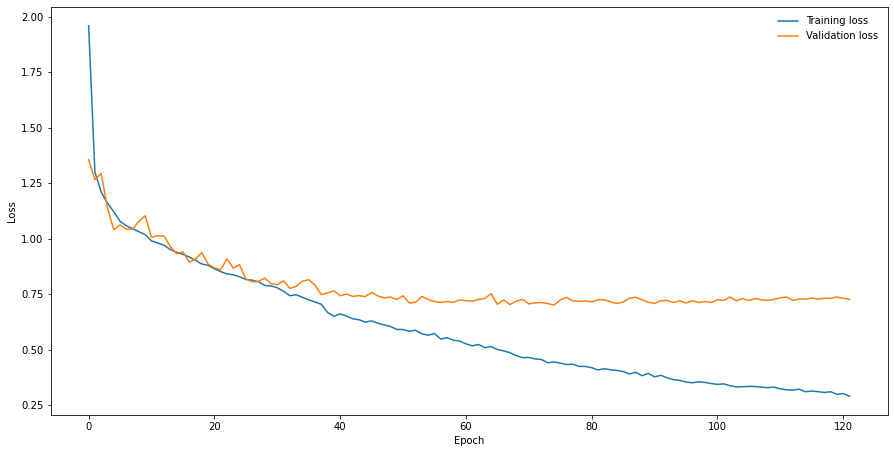

Accuracy: 0.7748, Balanced Accuracy: 0.7613, Precision: 0.7776, Recall: 0.7748, F1: 0.7754


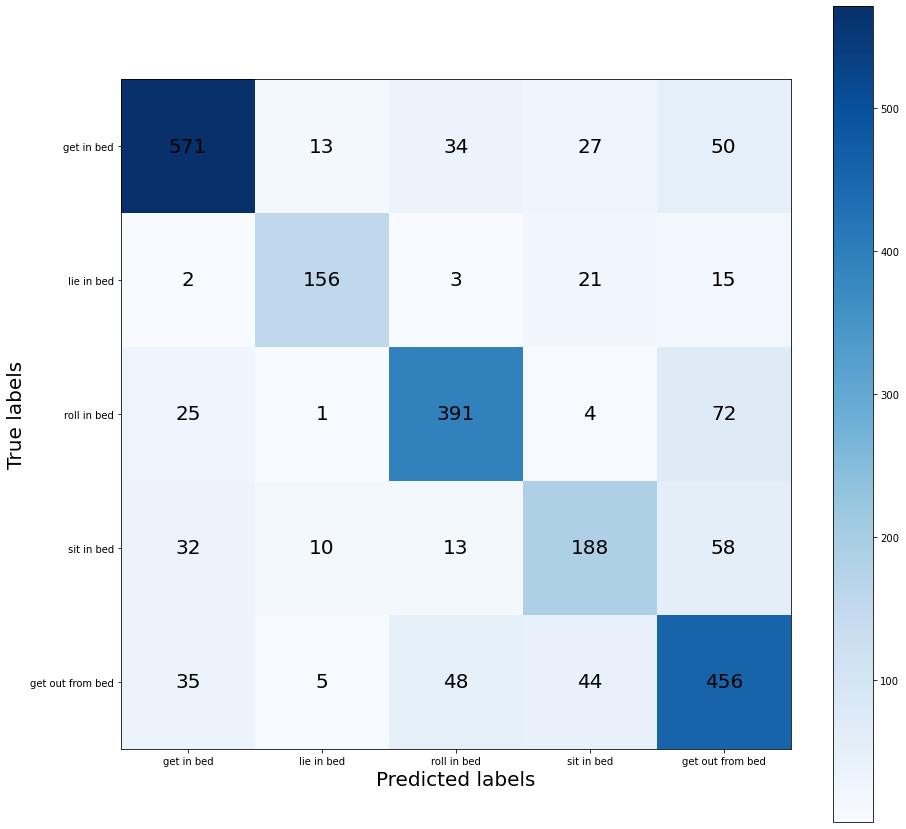

In [39]:
plt.figure(figsize = [15,7.5])
plt.plot(train_losses, label = "Training loss")
plt.plot(validation_losses, label = "Validation loss")
plt.xlabel( 'Epoch' )
plt.ylabel( 'Loss' )
plt.legend(frameon = False)
plt.savefig('LOSSESPLOT_BED_DS.pdf')
plt.show()

#names = ['walk' , 'fall' , 'stand up' , 'sit down' , 'bed']
names = ['get in bed' , 'lie in bed' , 'roll in bed' , 'sit in bed' , 'get out from bed']
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

test_loader = DataLoader(test_dataset)

def test(model, test_loader, criterion , names):
    model.eval()
    total_loss = 0
    total_correct = 0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1, keepdim=True)
            total_correct += pred.eq(target.view_as(pred)).sum().item()
            y_true.extend(target.tolist())
            y_pred.extend(pred.flatten().tolist())

    accuracy = total_correct / len(test_loader.dataset)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    print("Accuracy: {:.4f}, Balanced Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1: {:.4f}".format(accuracy, balanced_acc, precision, recall, f1))
    
    # Plot confusion matrix
    plt.figure(figsize = [15,15])
    cm = confusion_matrix(y_true, y_pred)
    plt.imshow(cm, cmap='Blues')
    plt.colorbar()
    plt.xticks([0,1,2,3,4],names)
    plt.yticks([0,1,2,3,4],names)
    plt.xlabel("Predicted labels", fontsize = 20)
    plt.ylabel("True labels", fontsize = 20)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], fontsize = 20, ha = 'center', va = 'center')
            
    plt.savefig('CONFUSIONMATRIX_BED_DS.pdf')
    plt.show()

test(model, test_loader, nn.CrossEntropyLoss() , names)